In [2]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)

from tqdm import tqdm

from src.utils import CIFAR
from src.model import CIFAR_CNN

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [3]:

def stochastic_gradient_sampling(model, optimizer, train_loader, criterion, device):
    model.train()
    full_gradients = {name: 0 for name, param in model.named_parameters()}
    
    # Первый цикл: вычисляем полные градиенты (усредненные по батчам)
    for images, labels in tqdm(train_loader, desc="Computing full gradients"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        for name, param in model.named_parameters():
            full_gradients[name] += param.grad
    
    # Усредняем полные градиенты по количеству батчей
    for name in full_gradients:
        full_gradients[name] /= len(train_loader)
    
    # Второй цикл: вычисляем разности с полными градиентами и сохраняем 2-норму
    gradients_diff = []
    for images, labels in tqdm(train_loader, desc="Computing gradient differences"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Для каждого батча считаем разницу в норме между полными и стохастическими градиентами
        gradient_diff = {name: (full_gradients[name] - param.grad).norm(p=2).item()
                         for name, param in model.named_parameters()}
        
        gradients_diff.append(gradient_diff)
    
    return gradients_diff


In [4]:
DEVICE = "mps"

# Папка с чекпоинтами
CHECKPOINT_DIR = f"{repo_root}/data/checkpoints/exp6"


In [5]:
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]

# Список для хранения моделей
models = []

# Загружаем модели
for checkpoint_file in checkpoint_files:
    checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_file)
    
    # Создаём экземпляр модели
    model = CIFAR_CNN().to(DEVICE)
    
    # Загружаем веса модели
    model.load_state_dict(torch.load(checkpoint_path))
    
    # Добавляем модель в список
    models.append(model)
    print(f"Model loaded from {checkpoint_path}")

Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_20.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_4.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_8.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_16.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion_gitlab/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_12.pth


In [6]:
batch_sizes = [ 64]
train_loader, test_loader = {}, {}

all_gradients_diff = {batch_size: [] for batch_size in batch_sizes}

for batch_size in batch_sizes:
    print(f"\nProcessing batch_size = {batch_size}")
    
    train_dataset, test_dataset, train_loader[batch_size], test_loader[batch_size] = CIFAR(batch_size=batch_size)
    
    for i, model in enumerate(models):
        print(f"Processing model {i+1}/{len(models)} for batch_size {batch_size}")
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # Пример оптимизатора
        criterion = torch.nn.CrossEntropyLoss()  # Пример критерия
        
        gradients_diff = stochastic_gradient_sampling(model, optimizer, train_loader[batch_size], criterion, DEVICE)
        
        all_gradients_diff[batch_size].append(gradients_diff)


Processing batch_size = 64
Processing model 1/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:21<00:00, 36.76it/s]


Processing model 2/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:21<00:00, 36.90it/s]


Processing model 3/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:21<00:00, 36.91it/s]


Processing model 4/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:21<00:00, 36.96it/s]


Processing model 5/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [03:34<00:00,  3.64it/s]


In [ ]:
batch_size = 64
checkpoint_idx = 0
all_gradients_diff[batch_size][checkpoint_idx]

[{'conv1.weight': 2.214191198348999,
  'conv1.bias': 1.6686014703282126e-07,
  'conv2.weight': 0.6492681503295898,
  'conv2.bias': 6.7234204870203484e-09,
  'conv3.weight': 0.685489296913147,
  'conv3.bias': 6.8489076632261e-09,
  'conv4.weight': 0.6911585330963135,
  'conv4.bias': 9.144113022330203e-09,
  'conv5.weight': 0.2356404811143875,
  'conv5.bias': 1.7377548289232436e-09,
  'conv6.weight': 0.08862863481044769,
  'conv6.bias': 6.196406165948076e-10,
  'bn64.weight': 0.15540875494480133,
  'bn64.bias': 0.09629381448030472,
  'bn128.weight': 0.20059803128242493,
  'bn128.bias': 0.1346185952425003,
  'bn256.weight': 0.39127475023269653,
  'bn256.bias': 0.2582852840423584,
  'bn512.weight': 0.10966729372739792,
  'bn512.bias': 0.09051727503538132,
  'fc.weight': 0.43506839871406555,
  'fc.bias': 0.03393160179257393},
 {'conv1.weight': 1.1257011890411377,
  'conv1.bias': 9.256153532533062e-08,
  'conv2.weight': 0.3655983507633209,
  'conv2.bias': 3.815883165003697e-09,
  'conv3.weig

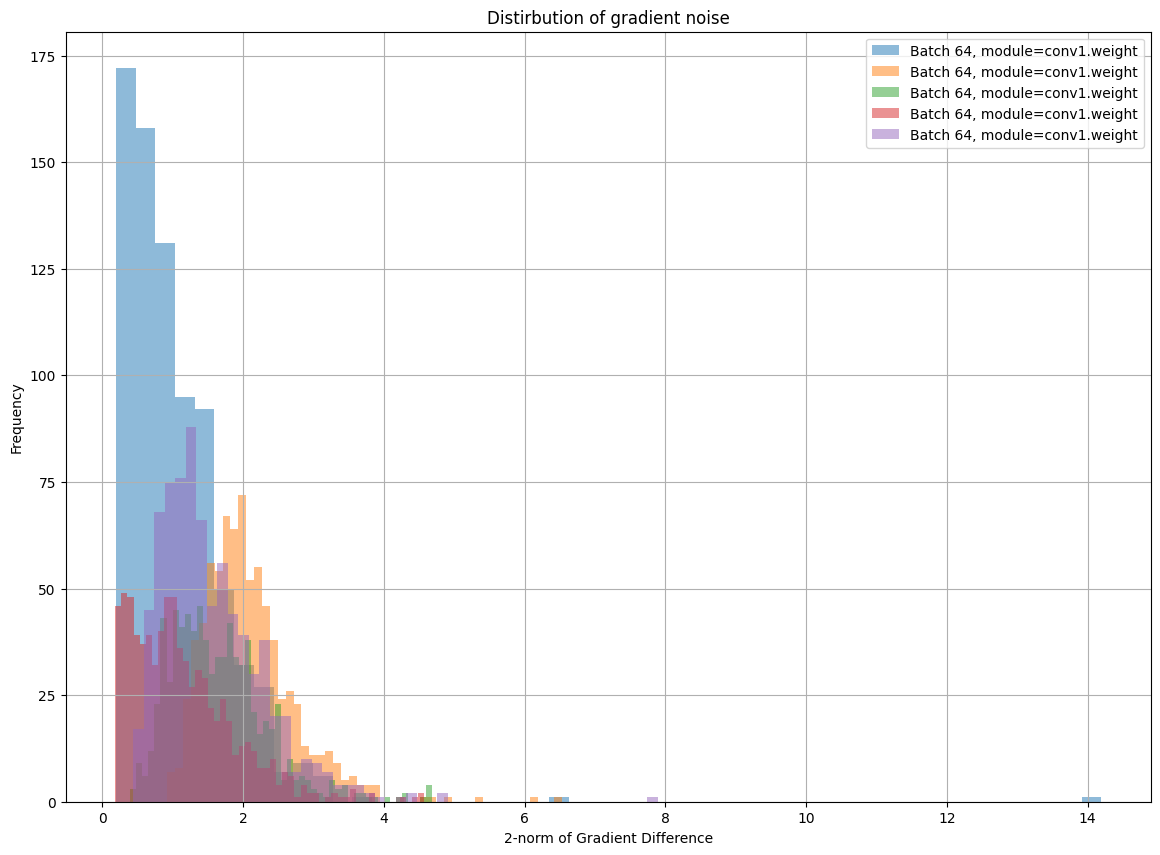

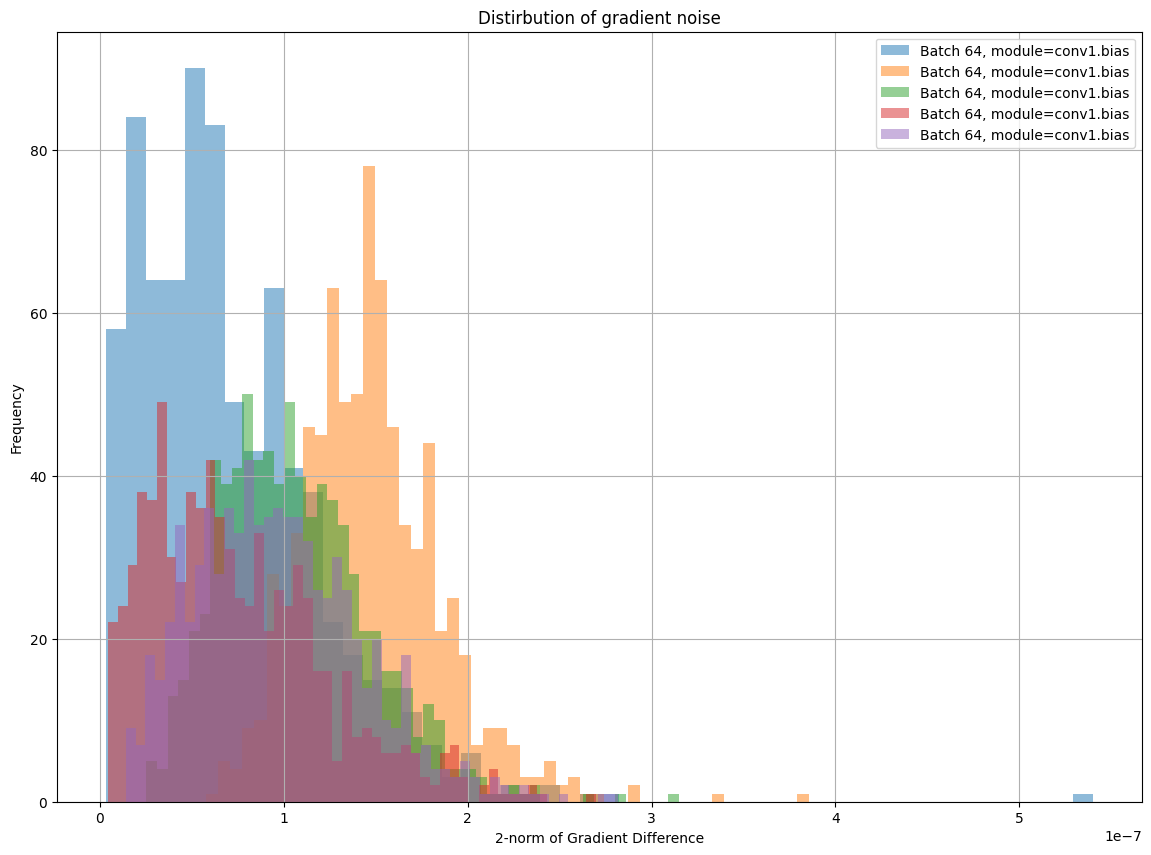

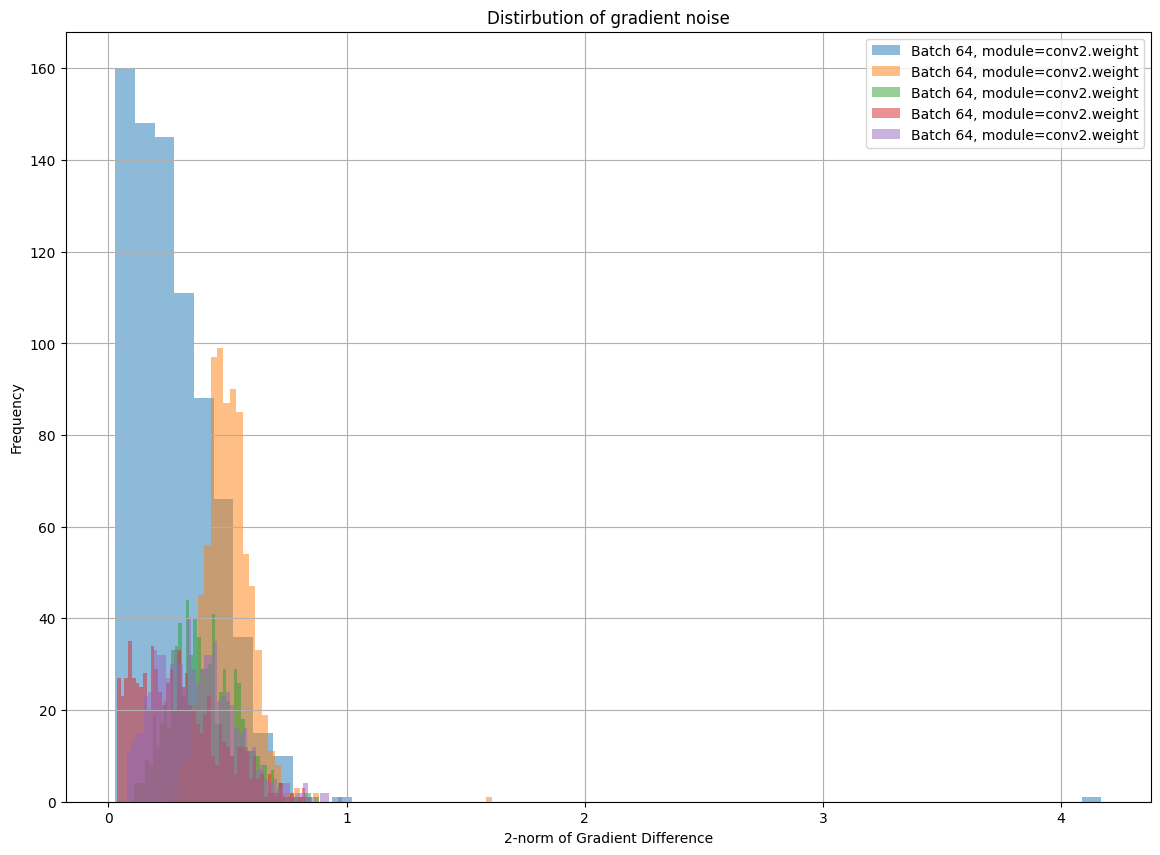

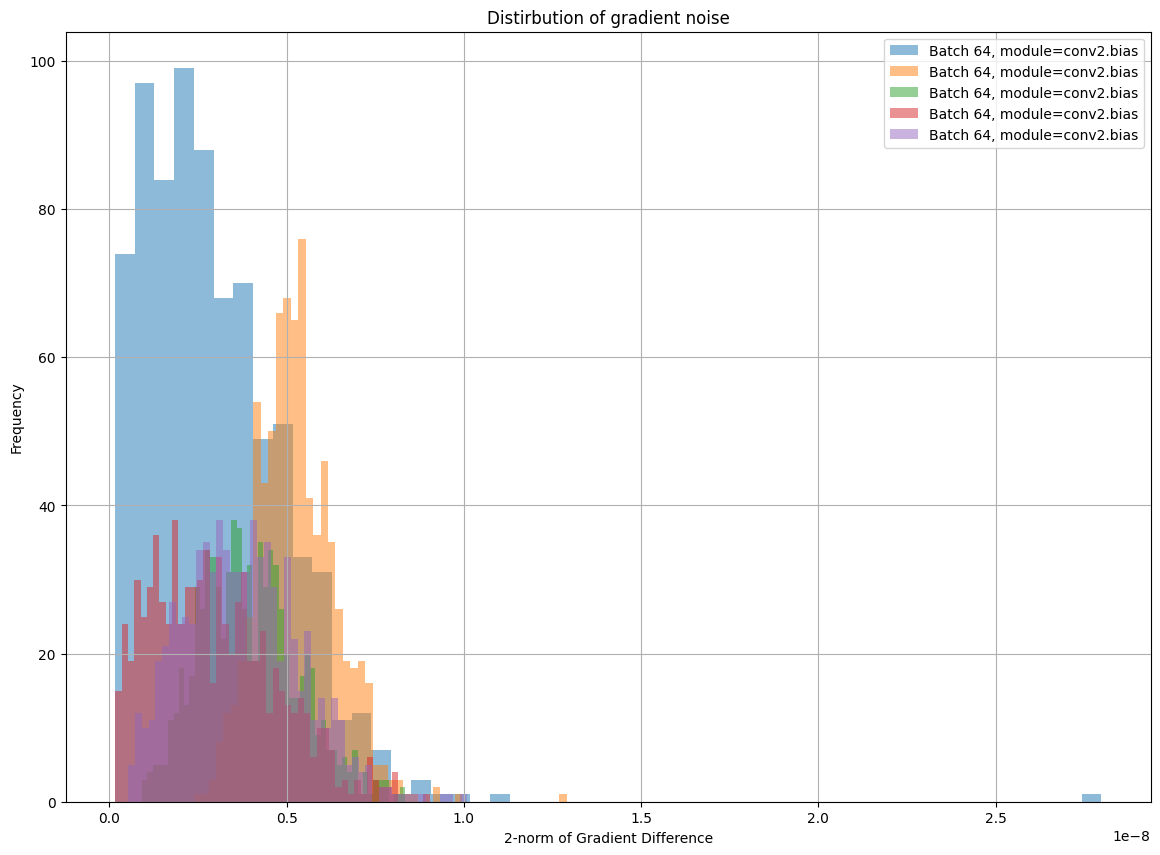

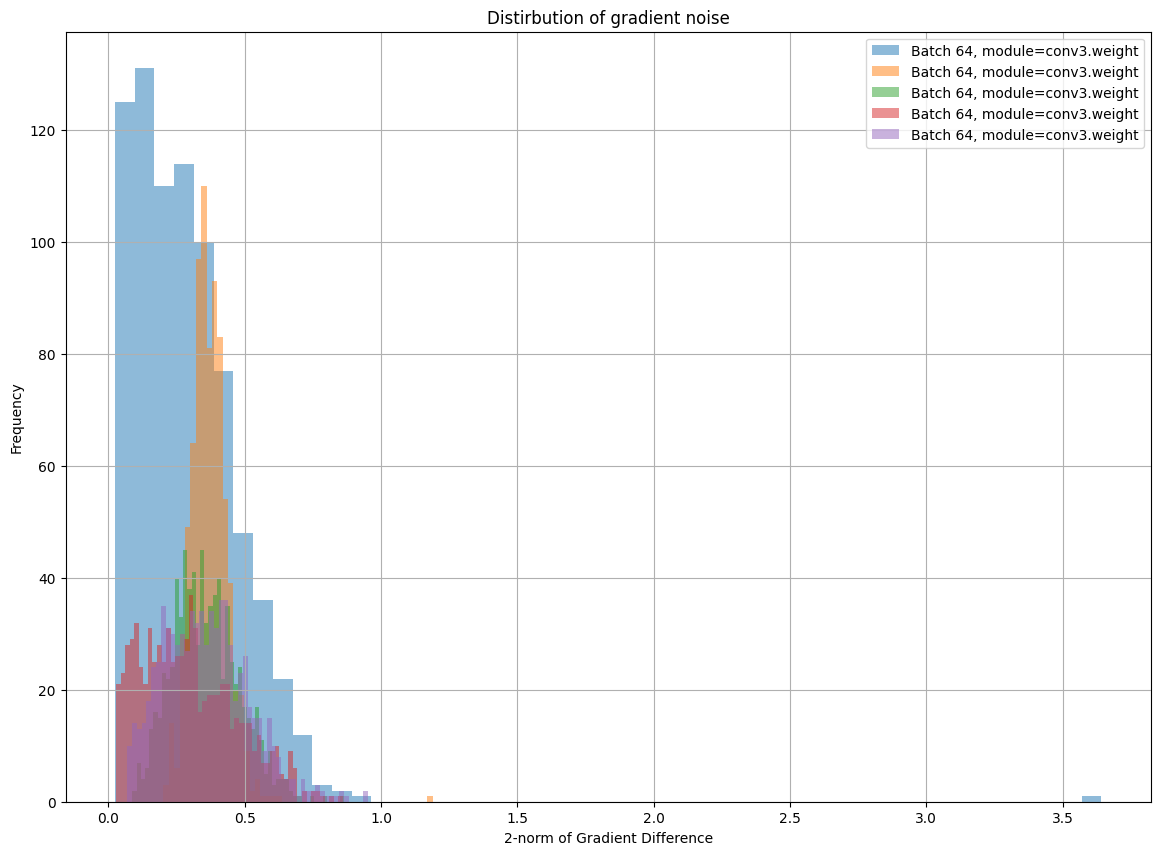

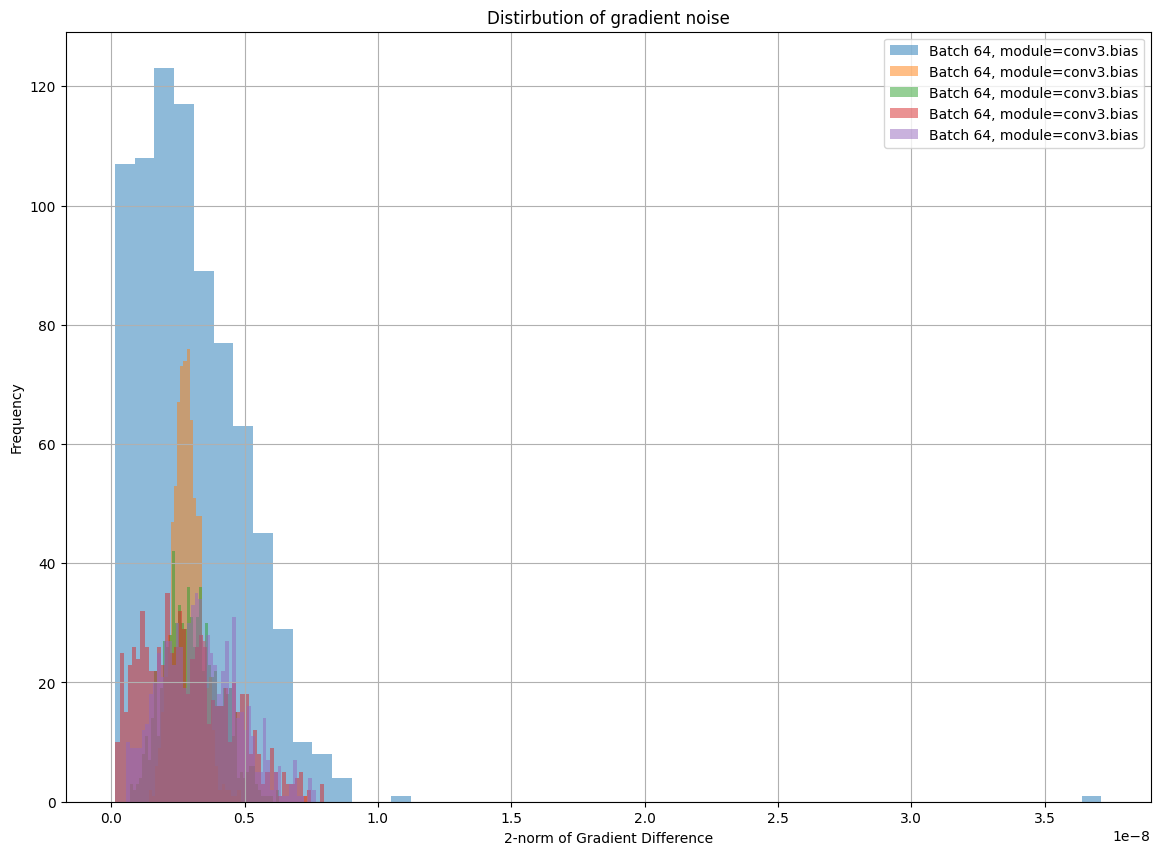

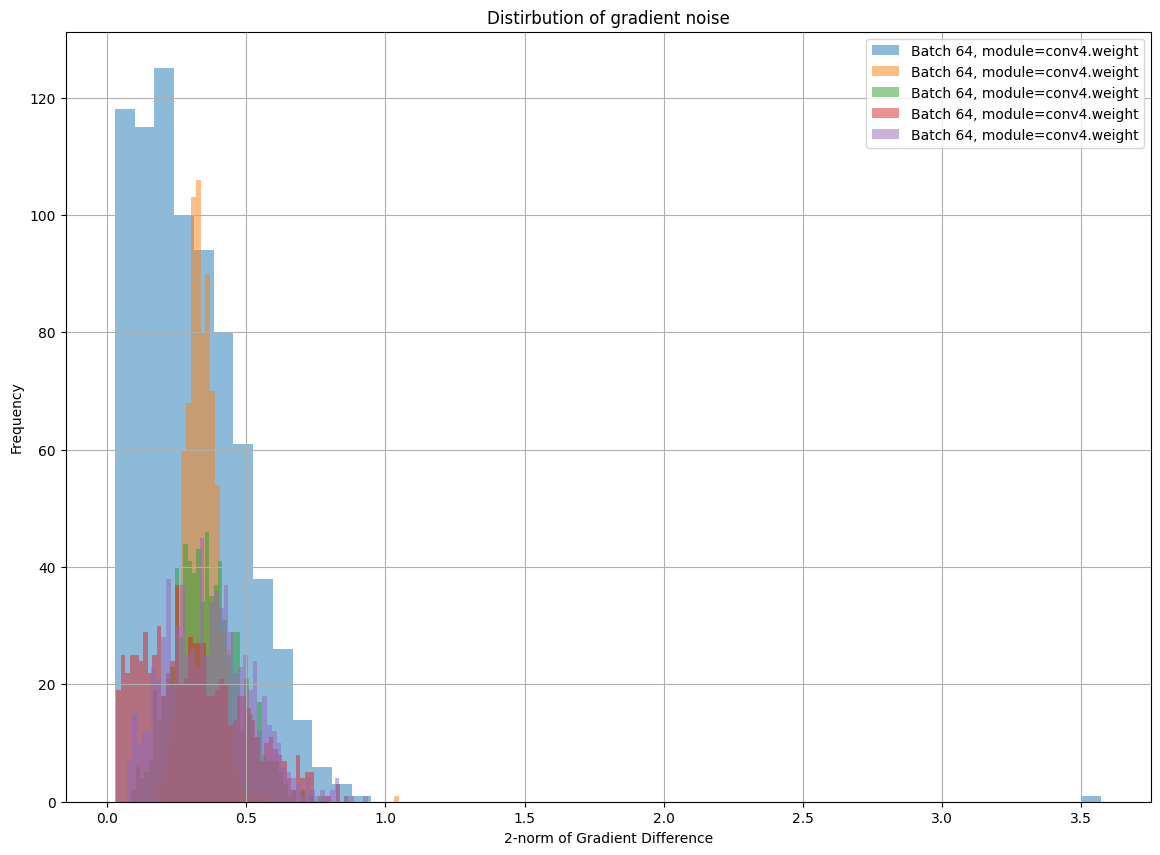

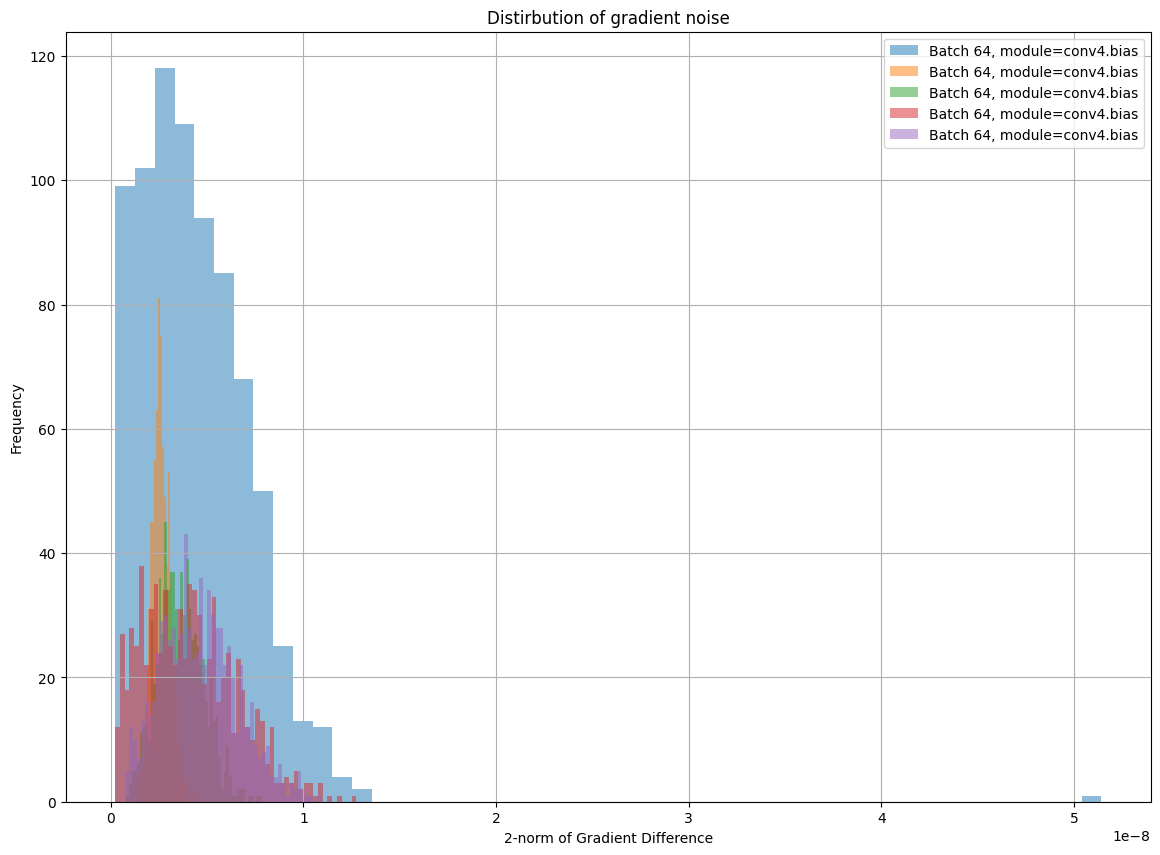

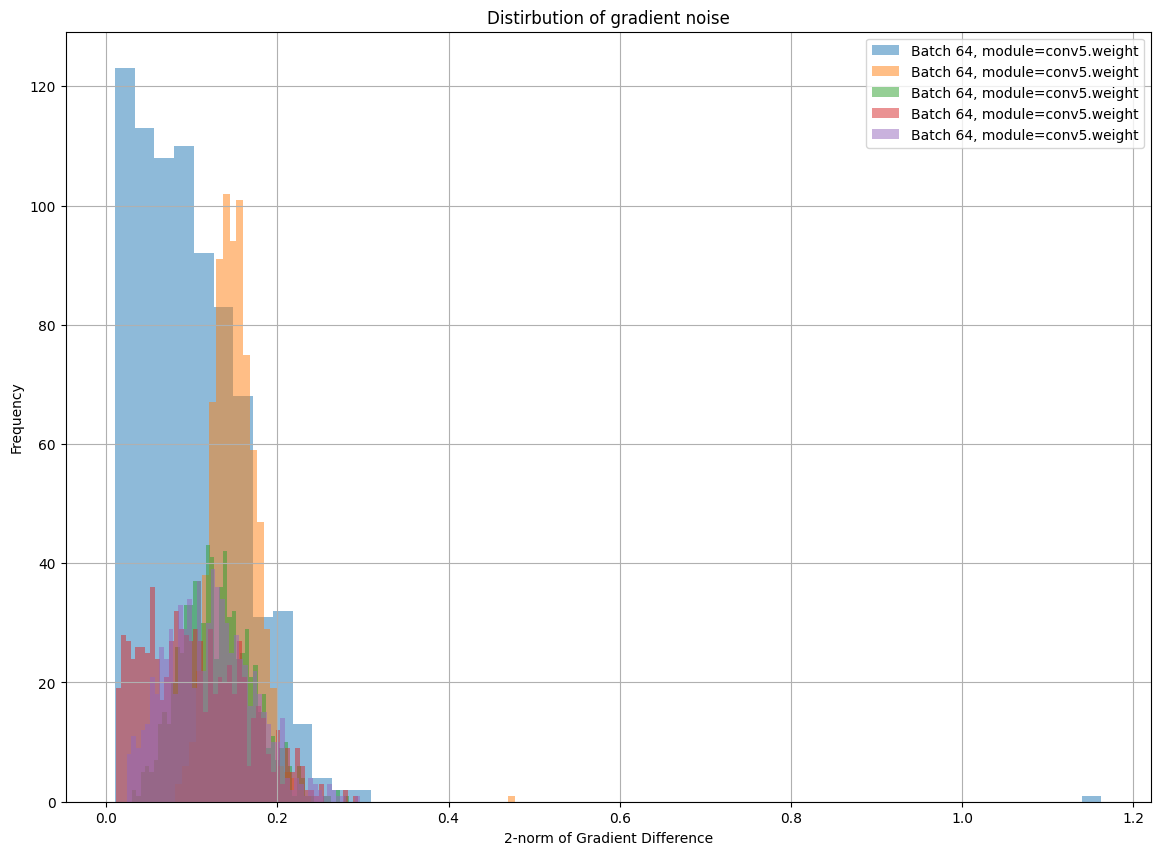

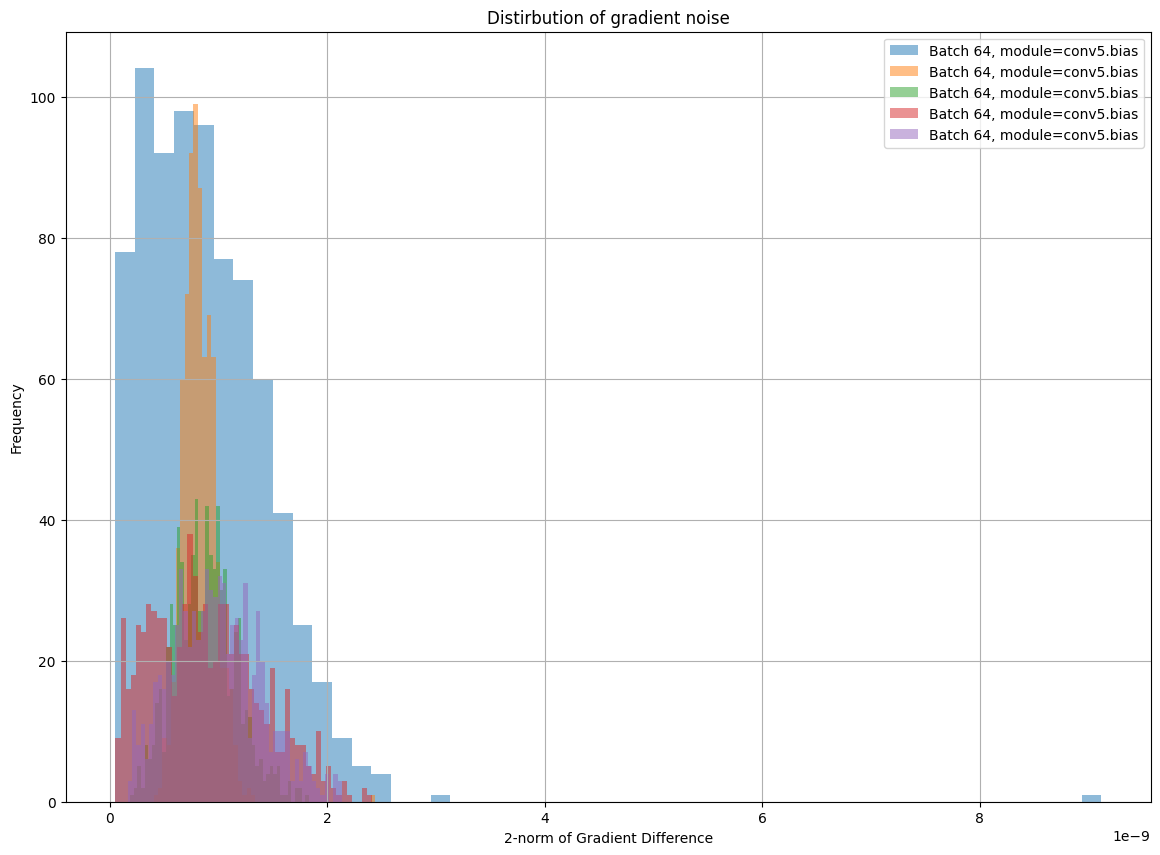

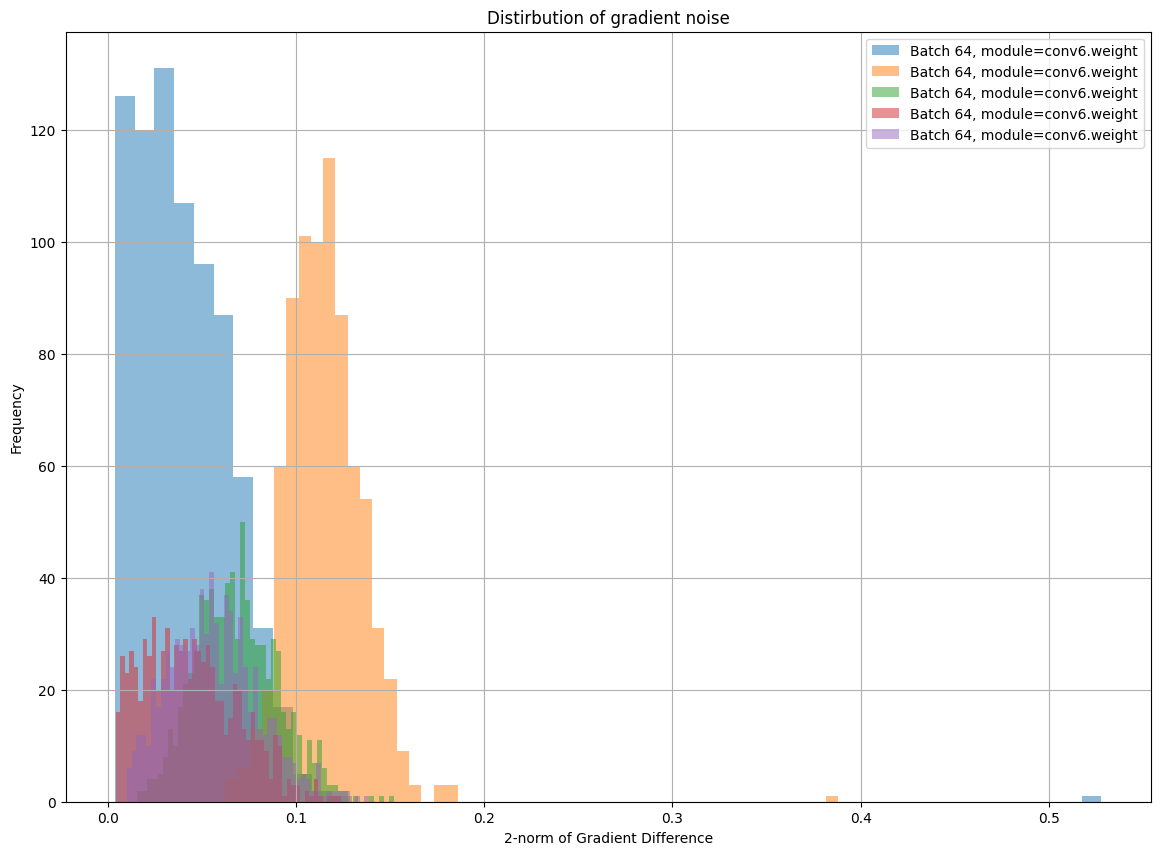

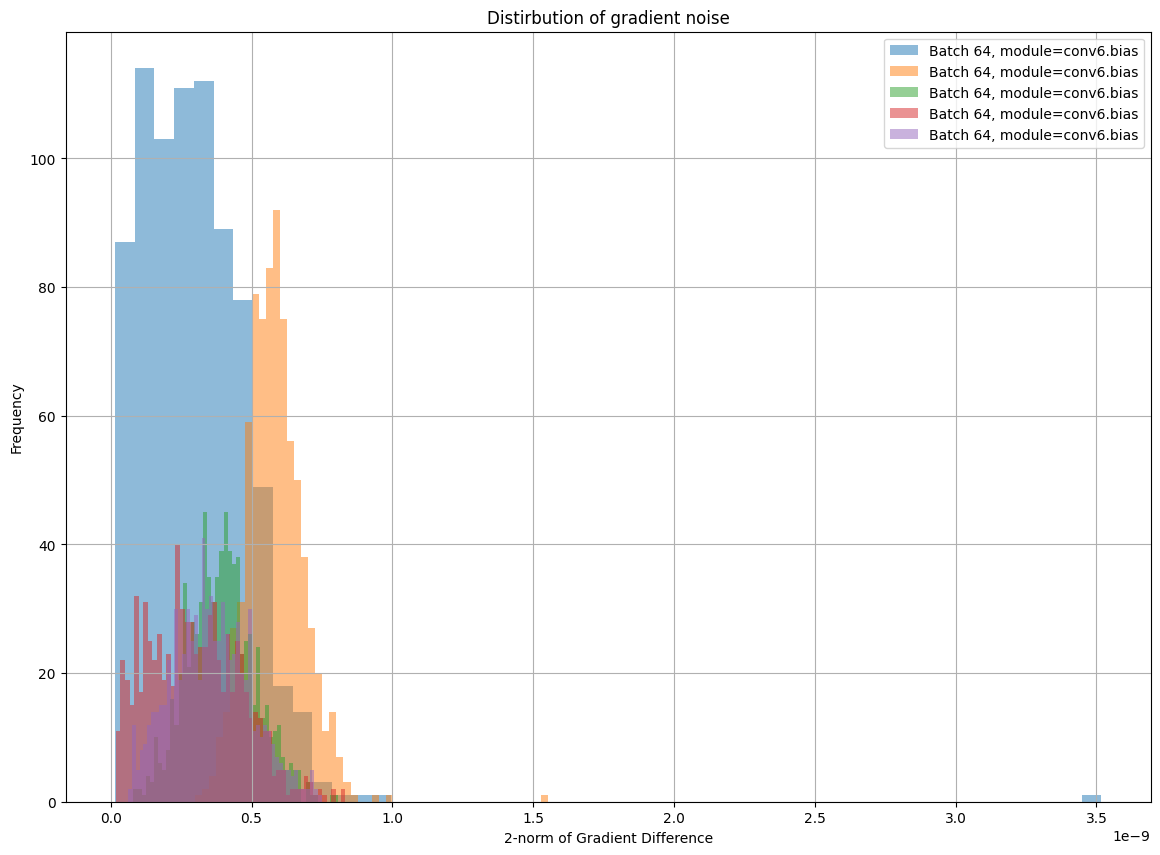

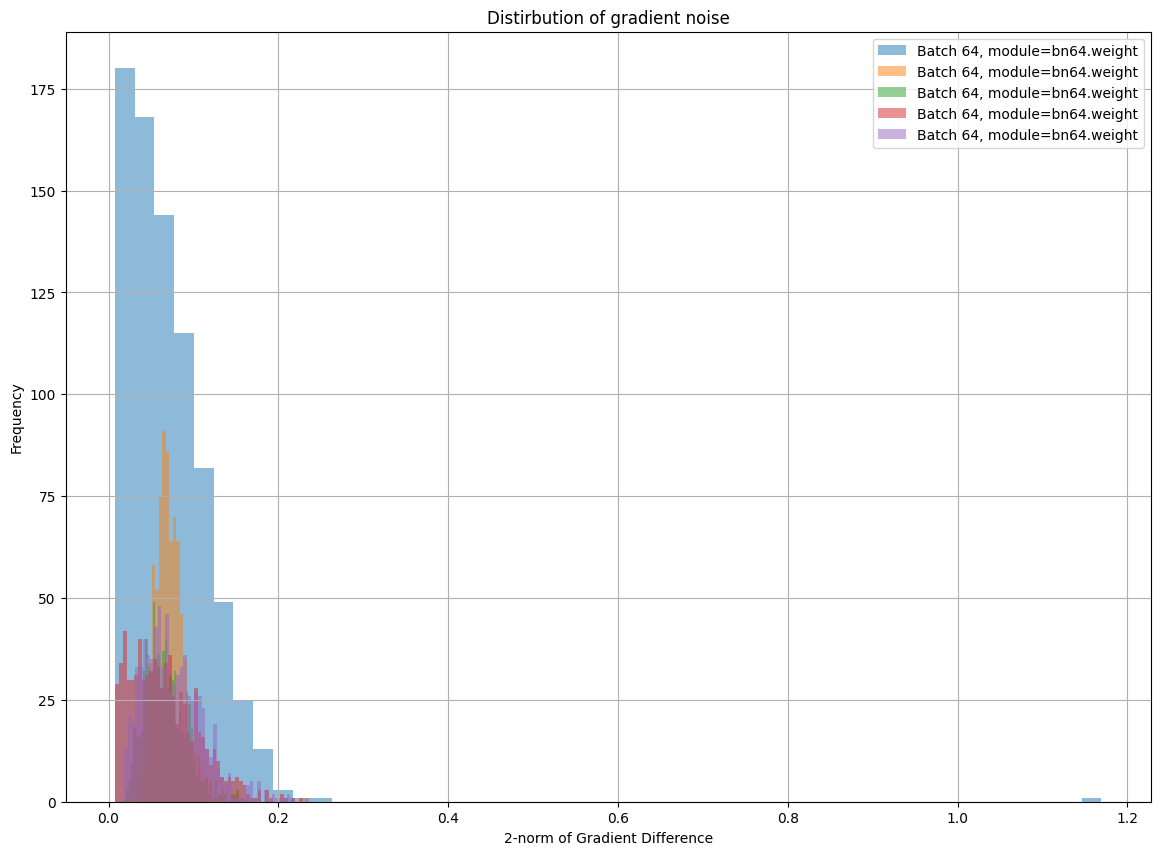

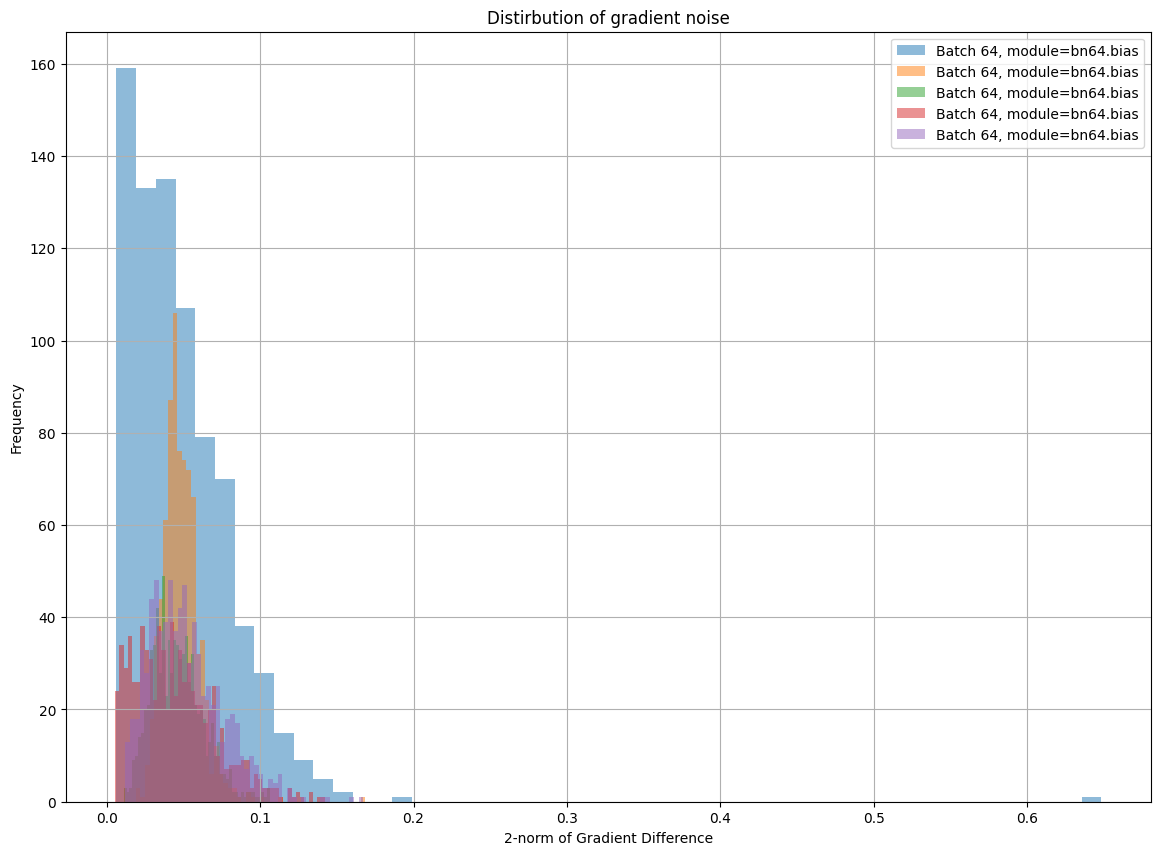

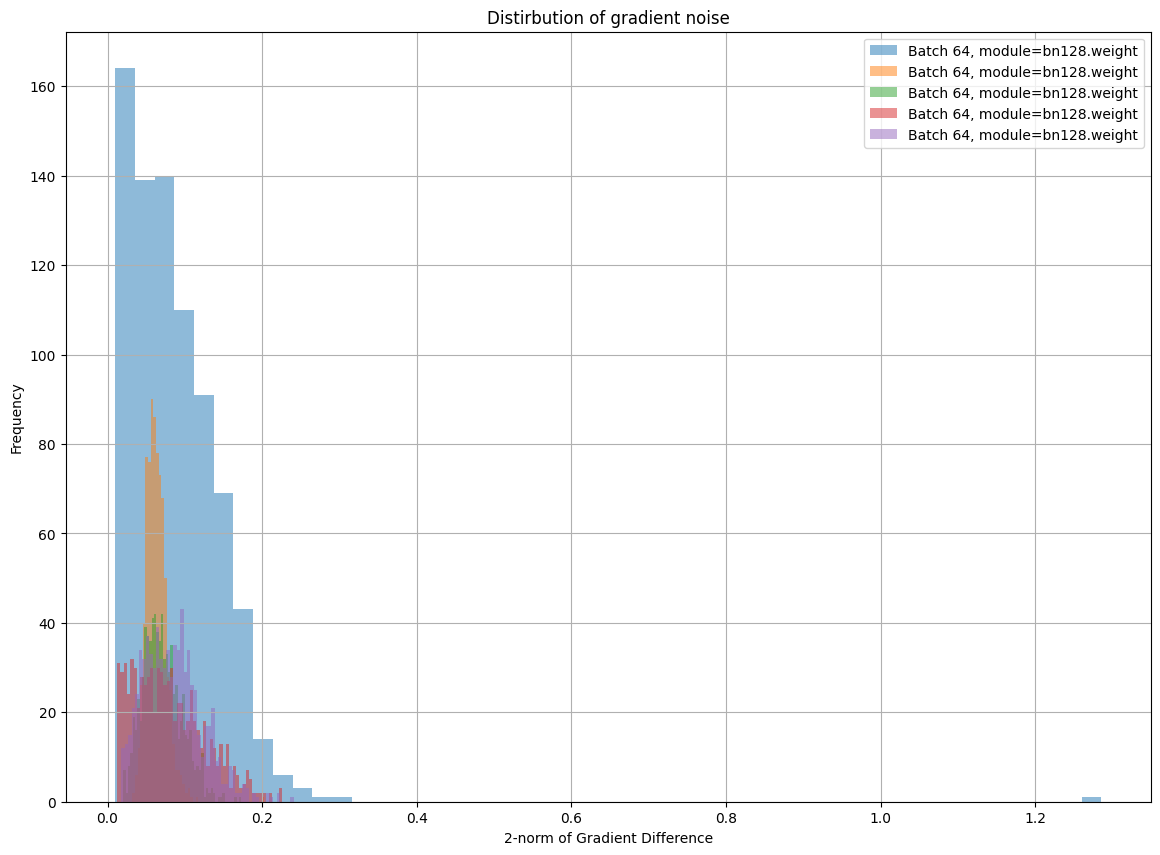

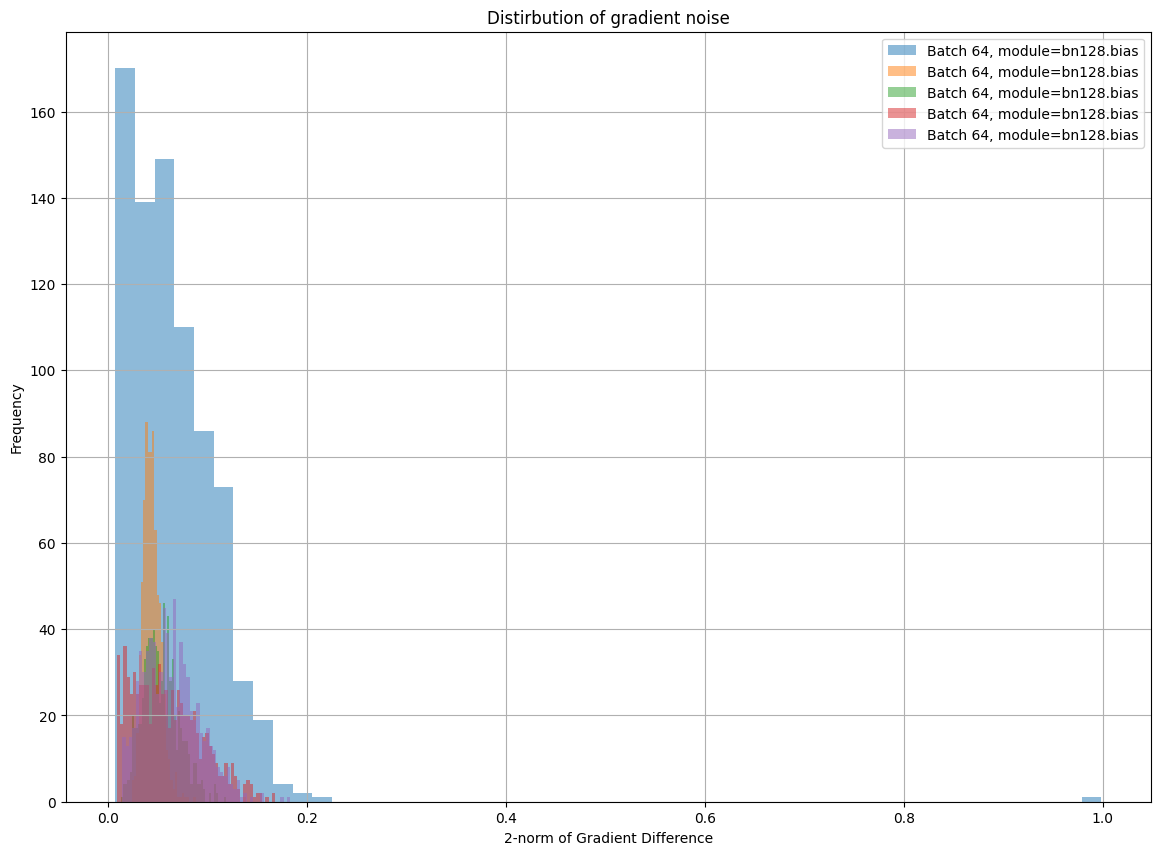

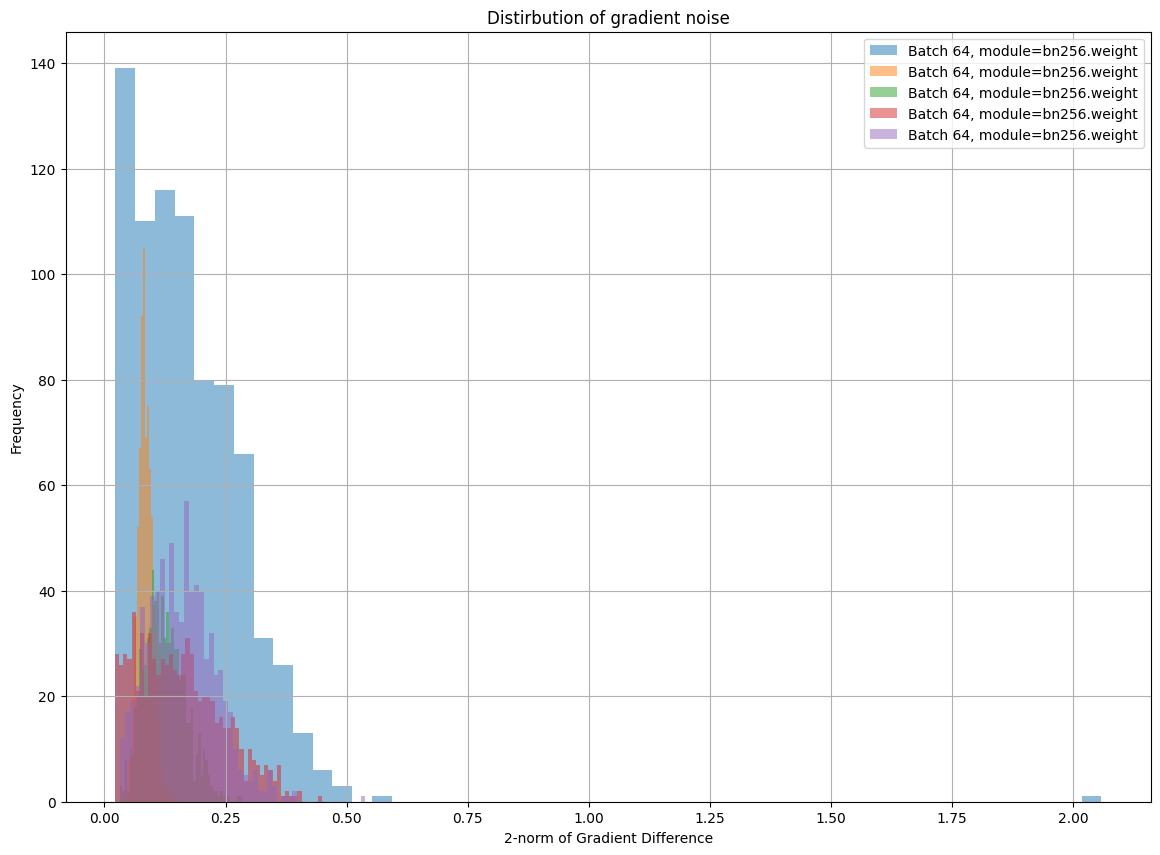

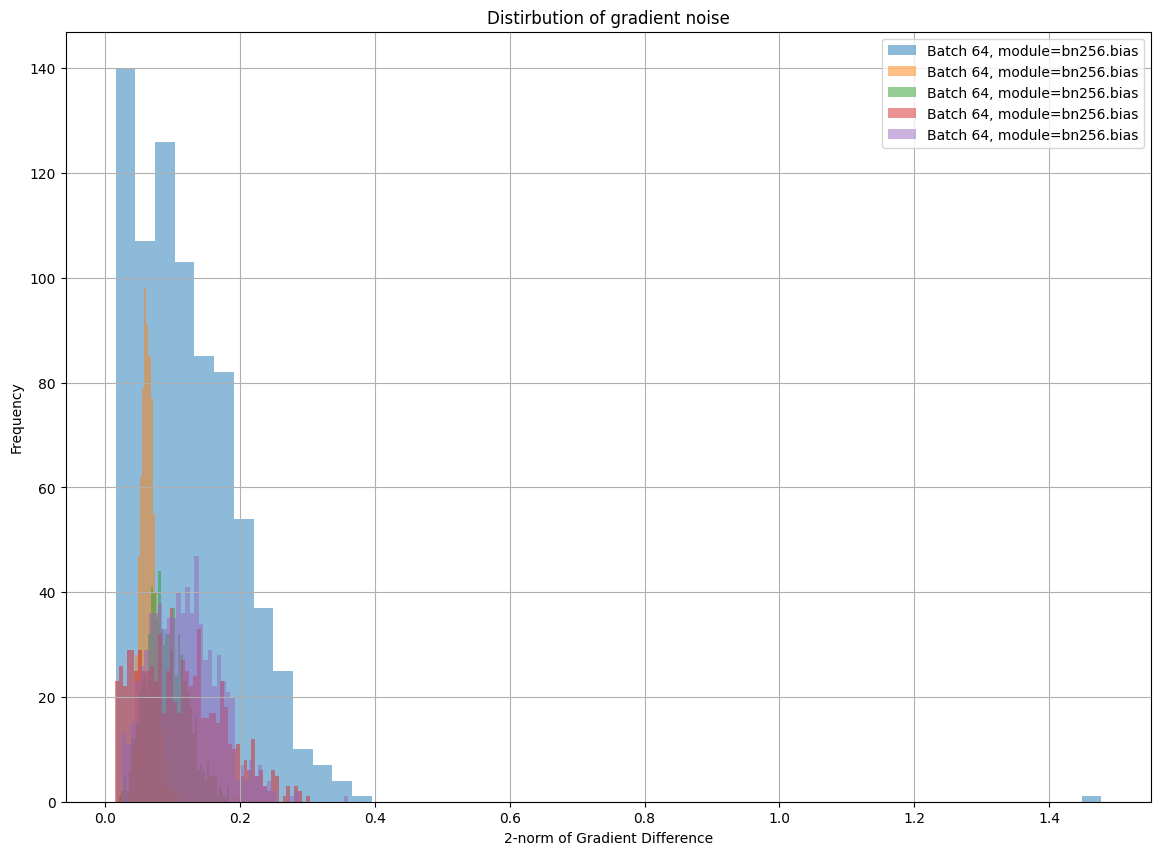

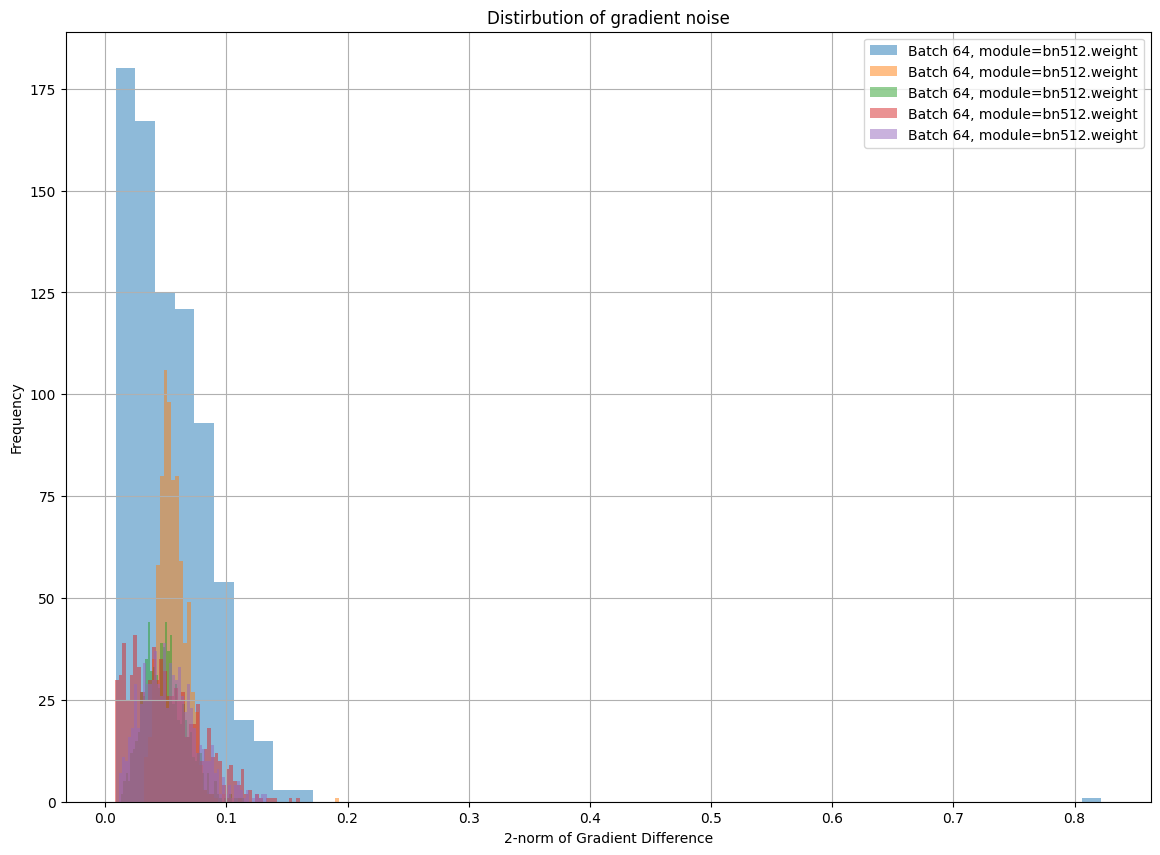

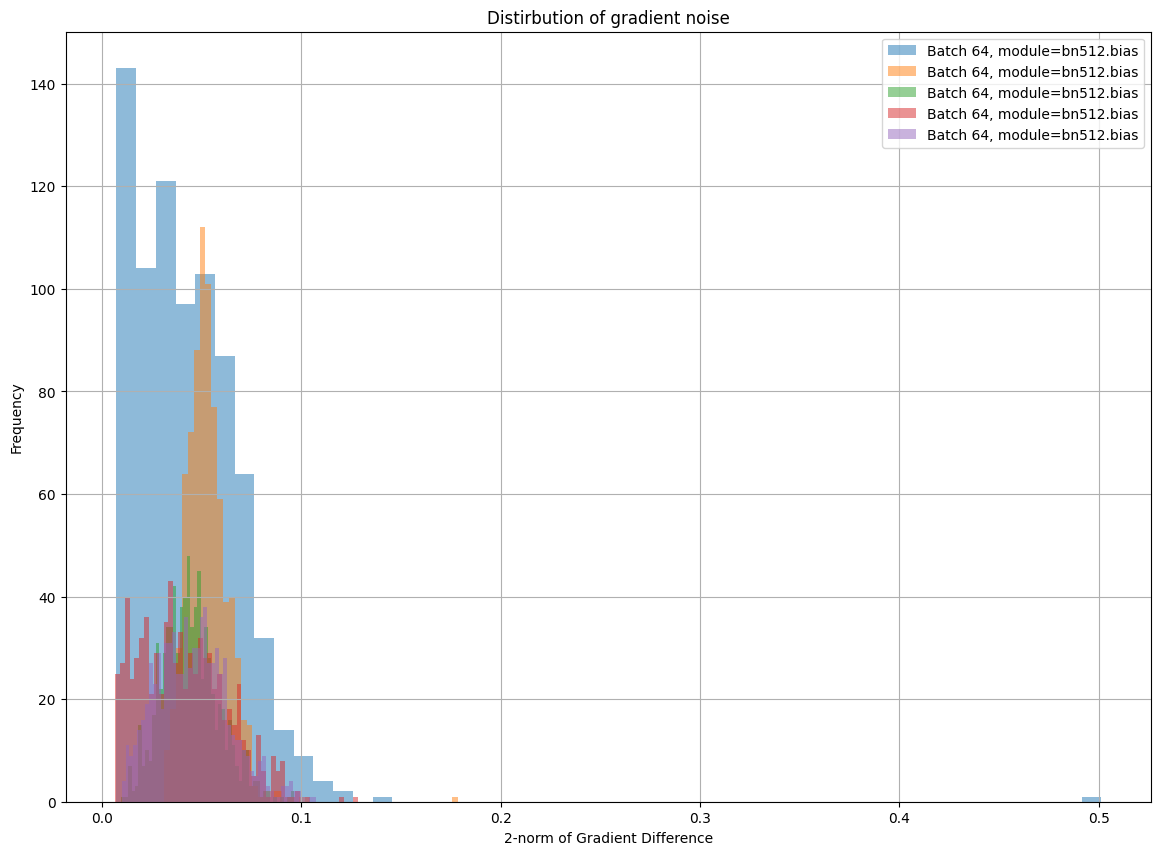

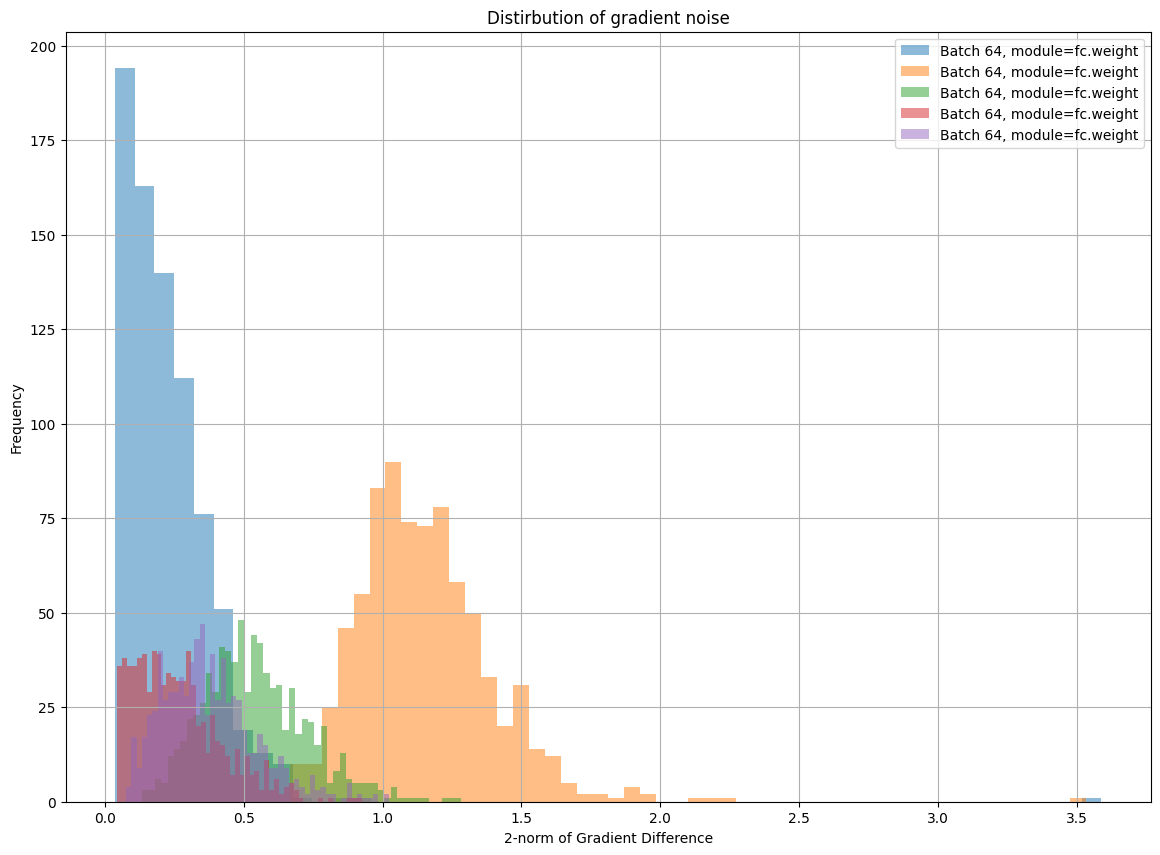

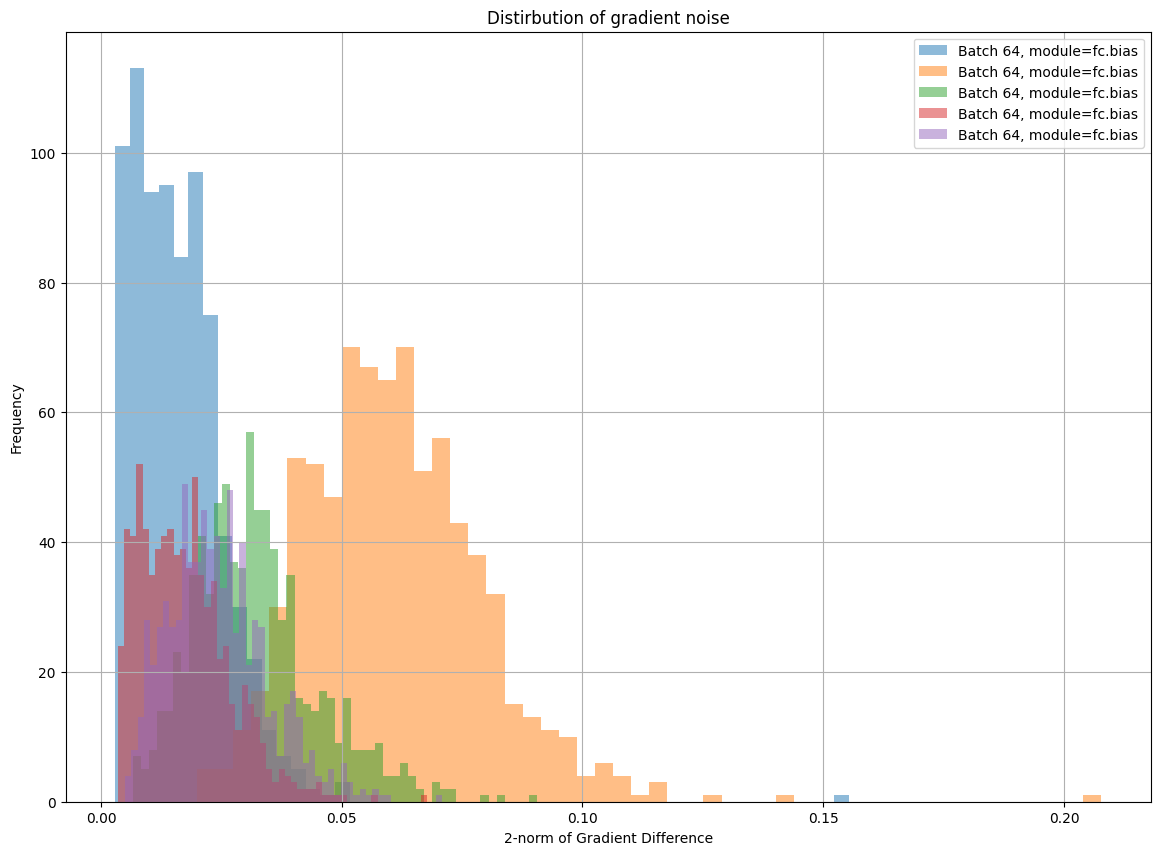

In [ ]:
for key, _ in model.named_parameters():
    plt.figure(figsize=(14, 10))

    for batch_size in batch_sizes:
        for checkpoint_idx in range(len(all_gradients_diff[batch_size])):
            values = [ v[key] for v in all_gradients_diff[batch_size][checkpoint_idx] ]
            plt.hist(values, bins=50, alpha=0.5, label=f'Batch {batch_size}, module={key}')
                    
    # Добавляем описание и отображаем график
    plt.xlabel('2-norm of Gradient Difference')
    plt.ylabel('Frequency')
    plt.title('Distirbution of gradient noise')
    plt.legend()
    plt.grid(True)
    plt.show()



In [11]:
sample

{'conv1.weight': 2.214191198348999,
 'conv1.bias': 1.6686014703282126e-07,
 'conv2.weight': 0.6492681503295898,
 'conv2.bias': 6.7234204870203484e-09,
 'conv3.weight': 0.685489296913147,
 'conv3.bias': 6.8489076632261e-09,
 'conv4.weight': 0.6911585330963135,
 'conv4.bias': 9.144113022330203e-09,
 'conv5.weight': 0.2356404811143875,
 'conv5.bias': 1.7377548289232436e-09,
 'conv6.weight': 0.08862863481044769,
 'conv6.bias': 6.196406165948076e-10,
 'bn64.weight': 0.15540875494480133,
 'bn64.bias': 0.09629381448030472,
 'bn128.weight': 0.20059803128242493,
 'bn128.bias': 0.1346185952425003,
 'bn256.weight': 0.39127475023269653,
 'bn256.bias': 0.2582852840423584,
 'bn512.weight': 0.10966729372739792,
 'bn512.bias': 0.09051727503538132,
 'fc.weight': 0.43506839871406555,
 'fc.bias': 0.03393160179257393}